In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [2]:
def show(img):
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])

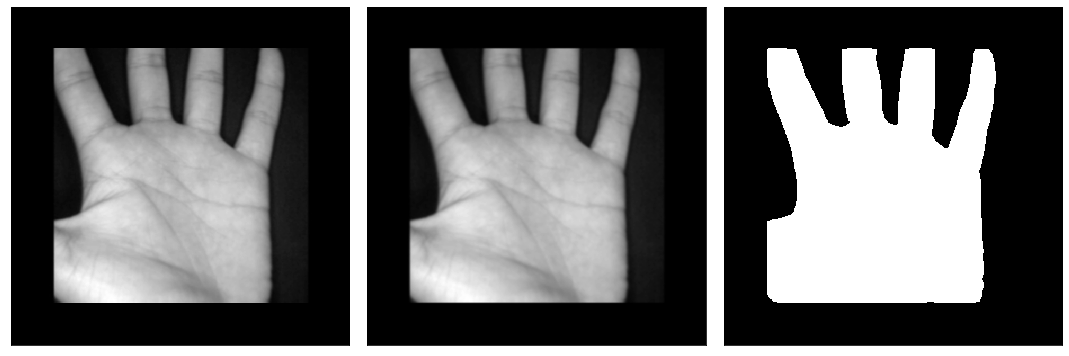

In [3]:
img_original = cv2.imread('1.jpg', 0)
h, w = img_original.shape
img = np.zeros((h+160,w), np.uint8)
img[80:-80,:] = img_original
plt.figure(figsize=(15,5))
plt.subplot(131)
show(img)
blur = cv2.GaussianBlur(img,(5,5),0)
plt.subplot(132)
show(blur)
_, th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.subplot(133)
show(th)
plt.tight_layout()
plt.show()

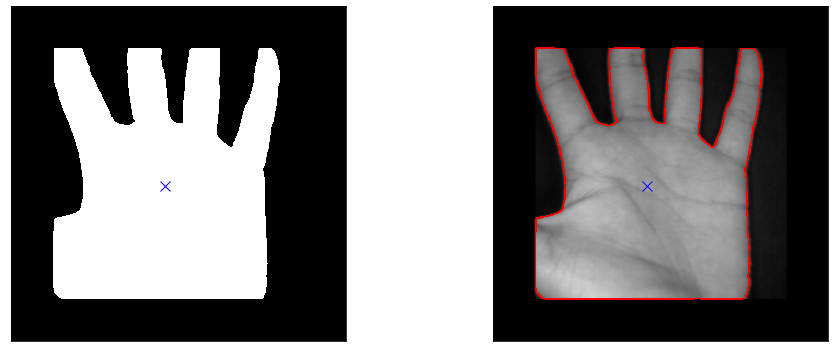

In [4]:
M = cv2.moments(th)
h, w = img.shape
x_c = M['m10'] // M['m00']
y_c = M['m01'] // M['m00']
plt.figure(figsize=(15,5))
plt.subplot(121)
show(th)
plt.plot(x_c, y_c, 'bx', markersize=10)
kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]]).astype(np.uint8)
erosion = cv2.erode(th,kernel,iterations=1)
boundary = th - erosion

cnt, _ = cv2.findContours(boundary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
img_c = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cnt = cnt[0]
img_cnt = cv2.drawContours(img_c, [cnt], 0, (255,0,0), 2)
plt.subplot(122)
plt.plot(x_c, y_c, 'bx', markersize=10)
show(img_cnt)
plt.tight_layout()
plt.show()

cnt = cnt.reshape(-1,2)
left_id = np.argmin(cnt.sum(-1))
cnt = np.concatenate([cnt[left_id:,:], cnt[:left_id,:]])

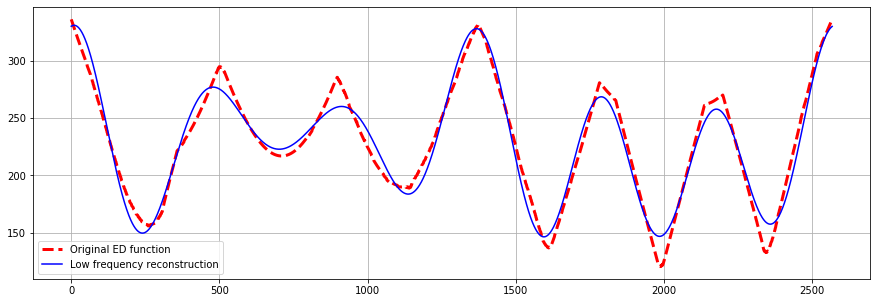

In [5]:
dist_c = np.sqrt(np.square(cnt-[x_c, y_c]).sum(-1))
f = np.fft.rfft(dist_c)
cutoff = 8
f_new = np.concatenate([f[:cutoff],0*f[cutoff:]])
dist_c_1 = np.fft.irfft(f_new)
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(dist_c, label='Original ED function', color='r', linewidth='3', linestyle='--')
plt.plot(dist_c_1, label='Low frequency reconstruction', color='b', linestyle='-')
plt.legend()
plt.show()

In [6]:
eta = np.square(np.abs(f_new)).sum()/np.square(np.abs(f)).sum()
print('Power Retained: {:.4f}{}'.format(eta*100,'%'))

Power Retained: 99.9036%


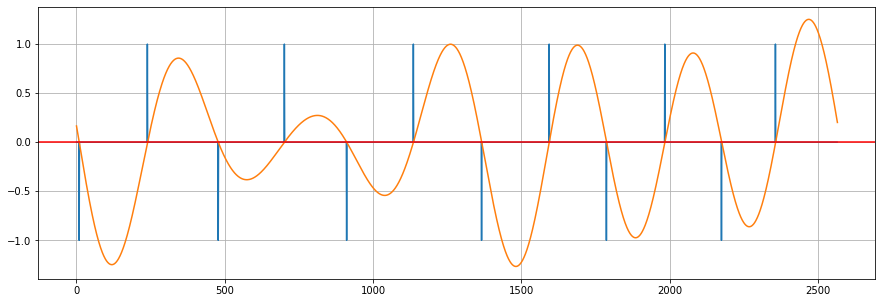

In [7]:
derivative = np.diff(dist_c_1)
sign_change = np.diff(np.sign(derivative))/2
plt.figure(figsize=(15,5))
plt.plot(sign_change)
plt.plot(derivative)
plt.axhline(y=0, color='r')
plt.grid()
plt.show()

The rotation of ROI is 11.20°


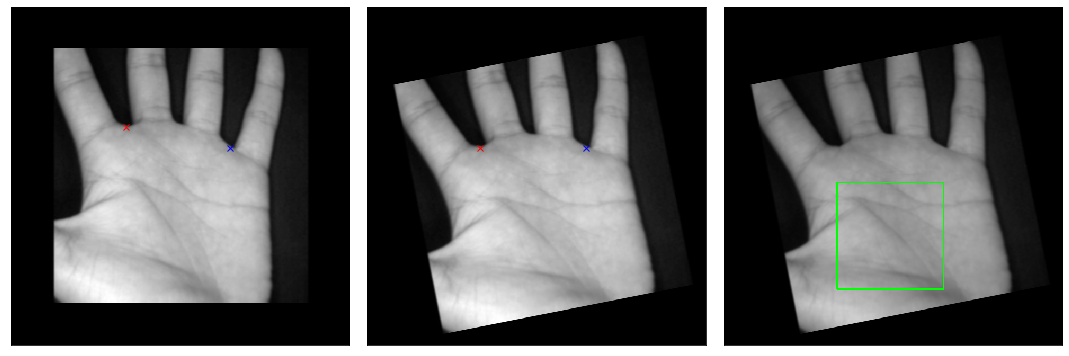

In [8]:
minimas = cnt[np.where(sign_change>0)[0]]
v1, v2 = minimas[-1], minimas[-3]
plt.figure(figsize=(15,5))
plt.subplot(131)
show(img)
plt.plot(v1[0], v1[1],'rx')
plt.plot(v2[0], v2[1],'bx')

plt.subplot(132)
theta = np.arctan2((v2-v1)[1], (v2-v1)[0])*180/np.pi
print('The rotation of ROI is {:.02f}\u00b0'.format(theta))
R = cv2.getRotationMatrix2D(tuple(v2),theta,1)
img_r = cv2.warpAffine(img,R,(w,h))
v1 = (R[:,:2] @ v1 + R[:,-1]).astype(np.int)
v2 = (R[:,:2] @ v2 + R[:,-1]).astype(np.int)
plt.plot(v1[0], v1[1],'rx')
plt.plot(v2[0], v2[1],'bx')
show(img_r)

ux = v1[0]
uy = v1[1] + (v2-v1)[0]//3
lx = v2[0]
ly = v2[1] + 4*(v2-v1)[0]//3
img_c = cv2.cvtColor(img_r, cv2.COLOR_GRAY2BGR)
cv2.rectangle(img_c, (lx,ly),(ux,uy),(0,255,0),2)
plt.subplot(133)
show(img_c)

plt.tight_layout()
plt.show()

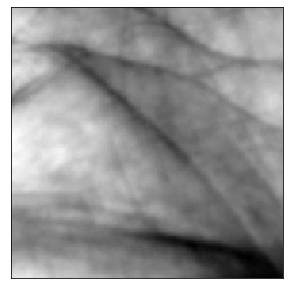

In [9]:
roi = img_r[uy:ly,ux:lx]
plt.figure(figsize=(5,5))
show(roi)